### Import Libraries and the dataset

In [459]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, tree
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import f_regression
from sklearn.model_selection import StratifiedKFold
from scipy import stats, interp
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import graphviz
import warnings

In [2]:
# Just simply to ignore some systemetic warning appears later
warnings.filterwarnings('ignore')

In [3]:
# Import the dataset
med_info = pd.read_csv("ps2_available_dataset.csv")

In [314]:
# Dataset preview
med_info

,treatment,age,blood_pressure,gender,blood_test,family_history,MeasureA,TestB,GeneA,GeneB,GeneC
0,1,74,94.113373,non-female,negative,False,-11.035690,-0.336843,double,1,0
1,1,56,83.337745,non-female,negative,False,-3.982345,-0.018734,none,1,1
2,0,37,81.759240,female,negative,False,6.205701,0.147933,double,1,1
3,1,54,88.549518,female,negative,False,-1.827613,-0.338373,none,1,1
4,0,73,82.171555,female,negative,nan,-14.637389,-0.369325,none,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,49,89.036800,non-female,negative,False,-1.384107,-0.333167,double,1,0
9996,0,64,90.848126,non-female,negative,nan,-6.560963,-0.015892,double,1,0
9997,0,54,82.028043,female,negative,False,-3.192784,-0.317267,none,1,0
9998,1,54,82.246645,female,negative,False,-4.138708,-0.042504,double,1,1


### Data Cleaning

In [315]:
# Check the NaN value of each features
med_info.isna().sum()

treatment         0
age               0
blood_pressure    0
gender            0
blood_test        0
family_history    0
MeasureA          0
TestB             0
GeneA             0
GeneB             0
GeneC             0
dtype: int64

In [316]:
# Family history is the feature that contains Nan. By replacing it with 'None', I will
# treat 'None' as the third value of family_history
med_info.fillna('None')
med_info['family_history']=med_info['family_history'].astype('str')

In [317]:
# From the value of blood pressure, it can be inferred that the unit of 'blood_pressure' is mmhg
# Remove the rows with blood_pressure = -99.00 (which may refers to missing data)
med_info = med_info[med_info['blood_pressure'] >= 0]

In [318]:
# Encode the other categorical features using one hot encoding
med_df = pd.get_dummies(med_info)
med_df.shape

(9995, 17)

In [319]:
# Dataset after one hot encoding
med_df

,treatment,age,blood_pressure,MeasureA,TestB,GeneB,GeneC,gender_female,gender_non-female,blood_test_negative,blood_test_positive,family_history_False,family_history_True,family_history_nan,GeneA_double,GeneA_none,GeneA_single
0,1,74,94.113373,-11.035690,-0.336843,1,0,0,1,1,0,1,0,0,1,0,0
1,1,56,83.337745,-3.982345,-0.018734,1,1,0,1,1,0,1,0,0,0,1,0
2,0,37,81.759240,6.205701,0.147933,1,1,1,0,1,0,1,0,0,1,0,0
3,1,54,88.549518,-1.827613,-0.338373,1,1,1,0,1,0,1,0,0,0,1,0
4,0,73,82.171555,-14.637389,-0.369325,1,1,1,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,49,89.036800,-1.384107,-0.333167,1,0,0,1,1,0,1,0,0,1,0,0
9996,0,64,90.848126,-6.560963,-0.015892,1,0,0,1,1,0,0,0,1,1,0,0
9997,0,54,82.028043,-3.192784,-0.317267,1,0,1,0,1,0,1,0,0,0,1,0
9998,1,54,82.246645,-4.138708,-0.042504,1,1,1,0,1,0,1,0,0,1,0,0


In [320]:
# Correlation matrix to see the general relationships between predictors and the treatment
corrMatrix = med_df.corr()
print (corrMatrix.iloc[0,:])

treatment               1.000000
age                    -0.148967
blood_pressure          0.096630
MeasureA                0.145517
TestB                   0.060390
GeneB                   0.026659
GeneC                   0.043758
gender_female          -0.330426
gender_non-female       0.330426
blood_test_negative     0.053359
blood_test_positive    -0.053359
family_history_False   -0.048968
family_history_True     0.134395
family_history_nan      0.020060
GeneA_double            0.000667
GeneA_none             -0.001548
GeneA_single            0.001122
Name: treatment, dtype: float64


In [321]:
# T-test to see the general relationships between predictors and the treatment
# first row: t-score, second row: p-value
t_test = f_regression(med_df.iloc[:,1:], med_df['treatment'])
t_columns = med_df.columns[1:]
t_test = pd.DataFrame(t_test, columns=t_columns)
print(t_test)

            age  blood_pressure      MeasureA         TestB     GeneB  \
0  2.267904e+02    9.418828e+01  2.161806e+02  3.657732e+01  7.107234   
1  1.073245e-50    3.593643e-22  1.971105e-48  1.519855e-09  0.007690   

       GeneC  gender_female  gender_non-female  blood_test_negative  \
0  19.170860   1.224767e+03       1.224767e+03         2.853327e+01   
1   0.000012  3.203795e-253      3.203795e-253         9.412585e-08   

   blood_test_positive  family_history_False  family_history_True  \
0         2.853327e+01          2.401985e+01         1.838129e+02   
1         9.412585e-08          9.684616e-07         1.657911e-41   

   family_history_nan  GeneA_double  GeneA_none  GeneA_single  
0            4.022868      0.004452    0.023943      0.012576  
1            0.044914      0.946804    0.877033      0.910713  


### Feature selection

#### Forward selection

In [366]:
#Seperate predictor and the predicted variable
med_df = shuffle(med_df)

y = med_df.iloc[:,:1].to_numpy().ravel()
X = med_df.iloc[:,1:]

    cycle         Added_feature  neg_mse
0       1         gender_female     0.69
1       2                   age     0.70
2       3   family_history_True     0.71
3       4        blood_pressure     0.71
4       5   blood_test_negative     0.72
5       6                 TestB     0.72
6       7  family_history_False     0.72
7       8   blood_test_positive     0.72
8       9     gender_non-female     0.72
9      10            GeneA_none     0.72
10     11          GeneA_single     0.72
11     12    family_history_nan     0.72
12     13          GeneA_double     0.72
13     14              MeasureA     0.72
14     15                 GeneC     0.72
15     16                 GeneB     0.72


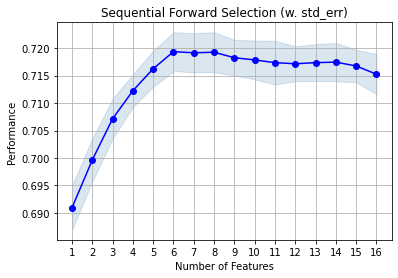

In [323]:
# Build the logistic regression model to use in feature selection
clf = linear_model.LogisticRegression(random_state=0)

# sequantial forward selection to help identify
sfs1 = sfs(clf,
           k_features=16,
           forward=True,
           floating=False,
           scoring='accuracy',
           cv=10)

sfs1 = sfs1.fit(X, y)

#output the added feature dataframe
f_cycle = []
f_names = []
f_added = []
f_nmse = []

for k,v in sfs1.subsets_.items():
    f_cycle.append(k)
    f_names.append(set(v['feature_names']))
    f_nmse.append(v['avg_score'].round(2))

for i in range(len(f_names)):
    if i == 0:
        f = f_names[0]
    else:
        f = f_names[i]^f_names[i-1]        
    f_added.append(list(f)[0])

result = pd.DataFrame({'cycle':f_cycle,'Added_feature':f_added,'accuracy':f_nmse})
print(result)

# Generate the performance figure
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. std_err)')
plt.grid()
plt.show()

#### Backward selection

In [324]:
# shuffle data for backward selection
med_df = shuffle(med_df)

y = med_df.iloc[:,:1].to_numpy().ravel()
X = med_df.iloc[:,1:]

    cycle      Removed_features  accuracy
0      16     gender_non-female      0.71
1      15                   age      0.72
2      14  family_history_False      0.72
3      13    family_history_nan      0.72
4      12   blood_test_positive      0.72
5      11        blood_pressure      0.72
6      10                 TestB      0.72
7       9   family_history_True      0.72
8       8         gender_female      0.72
9       7          GeneA_double      0.72
10      6              MeasureA      0.72
11      5            GeneA_none      0.71
12      4   blood_test_negative      0.71
13      3          GeneA_single      0.70
14      2                 GeneB      0.70
15      1                 GeneC      0.69


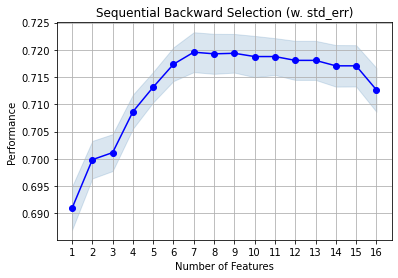

In [325]:
# Build the logistic regression model to use in backward feature selection
clf = linear_model.LogisticRegression(random_state=0)

sbs1 = sfs(clf,
           k_features=1,
           forward=False,
           floating=False,
           scoring='accuracy',
           cv=10)

sbs1 = sbs1.fit(X, y)

#output the added feature dataframe
b_cycle = []
b_names = []
b_removed = []
b_nmse = []

for k,v in sbs1.subsets_.items():
    b_cycle.append(k)
    b_names.append(set(v['feature_names']))
    b_nmse.append(v['avg_score'].round(2))

for i in range(len(b_names)-1,-1,-1):
    if i == len(b_names)-1:
        f = b_names[i]
    else:
        f = b_names[i]^b_names[i+1]        
    b_removed.append(list(f)[0])

result = pd.DataFrame({'cycle':b_cycle,'Removed_features':b_removed,'accuracy':b_nmse})
print(result)

# Generate the performance figure               
fig = plot_sfs(sbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. std_err)')
plt.grid()
plt.show()

In [367]:
#Combine the result from the forward selection and bfamily_history_True','blood_pressure'ackward selection, below features are selected
med_sf = med_df[['treatment','gender_female','age', 'family_history_True','blood_test_negative', 'blood_pressure','TestB']]

#Examine the correlation betweeen each features
corrMatrix = med_sf.corr()
print (corrMatrix.iloc[:,0])

treatment              1.000000
gender_female         -0.330426
age                   -0.148967
family_history_True    0.134395
blood_test_negative    0.053359
blood_pressure         0.096630
TestB                  0.060390
Name: treatment, dtype: float64


In [368]:
# T-test between each features and price, all the selected features are statiscally significant related to the treatment
features = ['gender_female','age', 'family_history_True','blood_test_negative', 'blood_pressure','TestB']
f_score = f_regression(med_sf.iloc[:,1:], med_sf['treatment'])
feature_t_score = pd.DataFrame({'features':features, 't_score':f_score[0], 'p-value':f_score[1]}).sort_values(by=['t_score'], ascending=False)
feature_t_score

,features,t_score,p-value
0,gender_female,1224.767450,3.203795e-253
1,age,226.790407,1.073245e-50
2,family_history_True,183.812896,1.657911e-41
4,blood_pressure,94.188282,3.593643e-22
5,TestB,36.577316,1.519855e-09
3,blood_test_negative,28.533273,9.412585e-08


### Feature Engineering

#### Age X Treatment

Text(0, 0.5, 'Frequency')

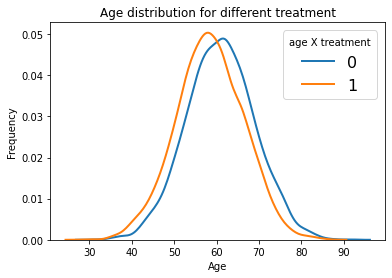

In [471]:
# Plot out the distribution of age for each value of the treatment
treatment = [0, 1]

for t in treatment:
    subset = med_sf[med_sf['treatment'] == t]
    sns.distplot(subset['age'], hist=False, kde=True, 
                 kde_kws={'linewidth': 2}, label = t)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'age X treatment')
plt.title('Age distribution for different treatment')
plt.xlabel('Age')
plt.ylabel('Frequency')

#### Blood Pressure X Treatment

Text(0, 0.5, 'Frequency')

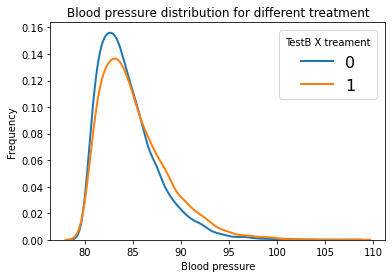

In [472]:
# Plot out the distribution of blood_pressure for each value of the treatment
treatment = [0, 1]

for t in treatment:
    subset = med_sf[med_sf['treatment'] == t]
    sns.distplot(subset['blood_pressure'], hist=False, kde=True, 
                 kde_kws={'linewidth': 2}, label = t)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'TestB X treament')
plt.title('Blood pressure distribution for different treatment')
plt.xlabel('Blood pressure')
plt.ylabel('Frequency')

#### TestB X Treatment

Text(0, 0.5, 'Frequency')

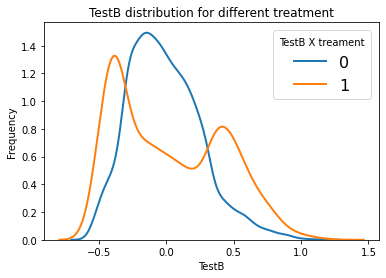

In [473]:
# Plot out the distribution of TestB for each value of the treatment
treatment = [0, 1]

for t in treatment:
    subset = med_sf[med_sf['treatment'] == t]
    sns.distplot(subset['TestB'], hist=False, kde=True, 
                 kde_kws={'linewidth': 2}, label = t)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'TestB X treament')
plt.title('TestB distribution for different treatment')
plt.xlabel('TestB')
plt.ylabel('Frequency')

#### Test B Absolute Value X Treatment

In [372]:
med_sf['TestB_abs'] = med_sf['TestB'].abs()
med_sf.head()

,treatment,gender_female,age,family_history_True,blood_test_negative,blood_pressure,TestB,TestB_abs
739,0,0,63,0,1,81.124948,0.013605,0.013605
5419,0,1,58,0,1,89.280816,-0.191927,0.191927
8946,0,1,69,0,1,83.125487,-0.052280,0.052280
2232,0,1,72,0,1,82.517926,0.115020,0.115020
2906,1,1,58,0,1,87.325903,0.247713,0.247713


Text(0, 0.5, 'Frequency')

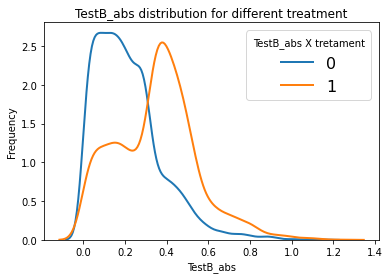

In [474]:
# Plot out the distribution of TestB_abs for each value of the treatment
treatment = [0, 1]

for t in treatment:
    subset = med_sf[med_sf['treatment'] == t]
    sns.distplot(subset['TestB_abs'], hist=False, kde=True, 
                 kde_kws={'linewidth': 2}, label = t)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'TestB_abs X tretament')
plt.title('TestB_abs distribution for different treatment')
plt.xlabel('TestB_abs')
plt.ylabel('Frequency')

### Model Training and validation

In [552]:
med_sf = med_sf.drop(columns=['TestB'])
train = med_sf.iloc[:-2000, :]
test = med_sf.iloc[-2000:, :]

In [553]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]

X_test =  test.iloc[:, 1:]
y_test = test.iloc[:, 0]

#### the default logistic regression model (with l2 regularization) with K-fold Cross Validation

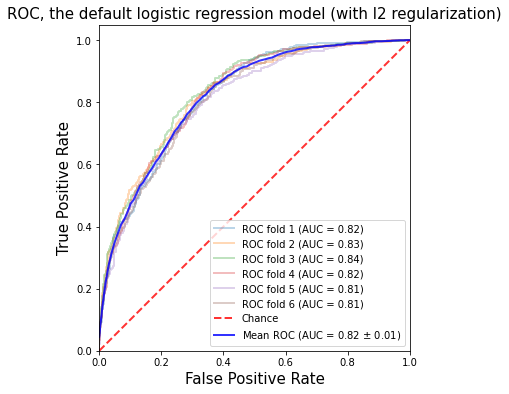

<Figure size 36000x36000 with 0 Axes>

In [554]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
clf = linear_model.LogisticRegression(random_state=0)

# Draw the plot
fig1 = plt.figure(figsize=[6,6])
ax = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 1

#calculate the fpr, tpr for each iteration
for train, test in cv.split(X_train, y_train):
    # Make the prediction
    prediction = clf.fit(X_train.iloc[train],y_train.iloc[train]).predict_proba(X_train.iloc[test])[:, 1]
    
    #Calculate fpr tpr
    fpr, tpr, threshold = roc_curve(y_train.iloc[test], prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Plot out the ROC curve for one fold
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

# Diagonal as the criterion
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

# Calculate the mean tpr and auc score for all the fold
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot out the average roc curve of all the folds
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

# Axis
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC, the default logistic regression model (with l2 regularization)', fontsize=15)
plt.legend(loc="lower right")
plt.figure(figsize = (500,500))
plt.show()

#### the logistic regression model with L1 regularization

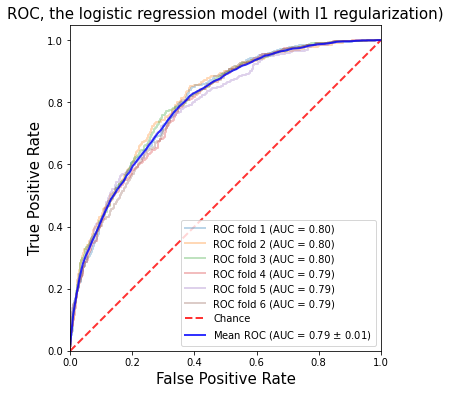

<Figure size 36000x36000 with 0 Axes>

In [555]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
clf = linear_model.LogisticRegression(penalty='l1', random_state=0, solver='saga')

# Draw the plot
fig1 = plt.figure(figsize=[6,6])
ax = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 1

#calculate the fpr, tpr for each iteration
for train, test in cv.split(X_train, y_train):
    # Make the prediction
    prediction = clf.fit(X_train.iloc[train],y_train.iloc[train]).predict_proba(X_train.iloc[test])[:, 1]
    
    #Calculate fpr tpr
    fpr, tpr, threshold = roc_curve(y_train.iloc[test], prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Plot out the ROC curve for one fold
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

# Diagonal as the criterion
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

# Calculate the mean tpr and auc score for all the fold
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot out the average roc curve of all the folds
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

# Axis
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC, the logistic regression model (with l1 regularization)', fontsize=15)
plt.legend(loc="lower right")
plt.figure(figsize = (500,500))
plt.show()

### Final Test

#### Data Preparing

In [557]:
#Examine the correlation betweeen each features
corrMatrix = med_sf.corr()
print (corrMatrix.iloc[:,0])

treatment              1.000000
gender_female         -0.330426
age                   -0.148967
family_history_True    0.134395
blood_test_negative    0.053359
blood_pressure         0.096630
TestB_abs              0.351589
Name: treatment, dtype: float64


In [558]:
# T-test between each features and price, all the selected features are statiscally significant related to the treatment
features = ['gender_female','age', 'family_history_True','blood_test_negative', 'blood_pressure','TestB_abs']
f_score = f_regression(med_fsf.iloc[:,1:], med_fsf['treatment'])
feature_t_score = pd.DataFrame({'features':features, 't_score':f_score[0], 'p-value':f_score[1]}).sort_values(by=['t_score'], ascending=False)
feature_t_score

,features,t_score,p-value
5,TestB_abs,1409.516485,1.076959e-288
0,gender_female,1224.767450,3.203795e-253
1,age,226.790407,1.073245e-50
2,family_history_True,183.812896,1.657911e-41
4,blood_pressure,94.188282,3.593643e-22
3,blood_test_negative,28.533273,9.412585e-08


#### Fit the model

In [559]:
# Train the logistic regression model
clf = linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)
# Predict the test set
y_result = clf.predict(X_test) # the decision results
y_predict = clf.predict_proba(X_test)[:, 1] # the probability results
print(y_predict)

[0.30464659 0.37529452 0.59644106 ... 0.08993006 0.08079782 0.05542676]


#### Feature influence

In [560]:
# print out the coefficients of each feature, calculate the influence of each feature to the treatment
# by the multiplication of coefficients and standard deviation
features = X_test.columns
std = X_test.std(axis=0).tolist()
coef = clf.coef_.ravel()
influence = pd.DataFrame({'features':features,'std':std, 'coef':coef})

influence['influence'] = influence['std']*influence['coef']
influence = influence.sort_values(by=['influence'], ascending=False,key=pd.Series.abs)
influence

,features,std,coef,influence
5,TestB_abs,0.190147,5.234637,0.995349
0,gender_female,0.478633,-1.849324,-0.885148
1,age,8.092201,-0.060087,-0.486232
2,family_history_True,0.099524,4.805062,0.478217
4,blood_pressure,3.276370,0.045531,0.149176
3,blood_test_negative,0.297389,0.500721,0.148909


#### Confusion Matrix

In [561]:
cm = confusion_matrix(y_test, y_result)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
print(cm)
accuracy = round((tp+tn)/(tn+fp+fn+tp),3)
precission = round(tp/(tp+fp),3)
fnr = round(fn/(tn+fn),3)
fpr1 = round(fp/(tp+fp), 3)
print('The accuracy is %s.'%accuracy)
print('The precission is %s.'%precission)
print('The false positive rate is %s.'%fpr1)
print('The false negative rate is %s.'%fnr)


[[1122  169]
 [ 313  396]]
The accuracy is 0.759.
The precission is 0.701.
The false positive rate is 0.299.
The false negative rate is 0.218.


In [562]:
# Adjust the threshold to reduce false negative rate
y_result_adjust = list()
for p in y_predict:
    if p < 0.25:
        y_result_adjust.append(0)
    else:
        y_result_adjust.append(1)  

In [563]:
# Confusion Matrix after threshold adjustment
cm = confusion_matrix(y_test, y_result_adjust)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
print(cm)
accuracy = round((tp+tn)/(tn+fp+fn+tp),3)
precission = round(tp/(tp+fp),3)
fnr = round(fn/(tn+fn),3)
fpr1 = round(fp/(tp+fp), 3)
print('The accuracy is %s.'%accuracy)
print('The precission is %s.'%precission)
print('The false positive rate is %s.'%fpr1)
print('The false negative rate is %s.'%fnr)


[[779 512]
 [ 82 627]]
The accuracy is 0.703.
The precission is 0.55.
The false positive rate is 0.45.
The false negative rate is 0.095.


#### ROC curve

In [564]:
# Calculate fpr, tpr to generated the roc curve and auc score
fpr, tpr, threshold = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
print('The auc score of the model is: %s.'%round(roc_auc,3))

The auc score of the model is: 0.832.


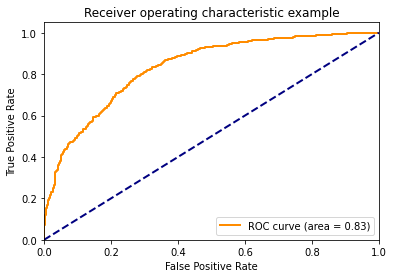

In [565]:
# Plot out the roc curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()